Without good orientation, manipulating reference points are quite hassle: directly move points are cumbersome; many techniques, e.g., projection (shrink wrap) constraint, become more of annoyance than helping.

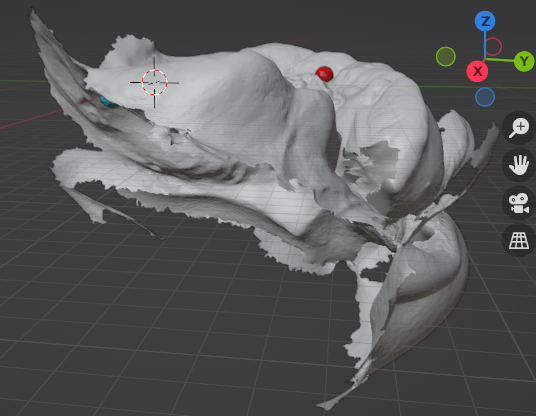

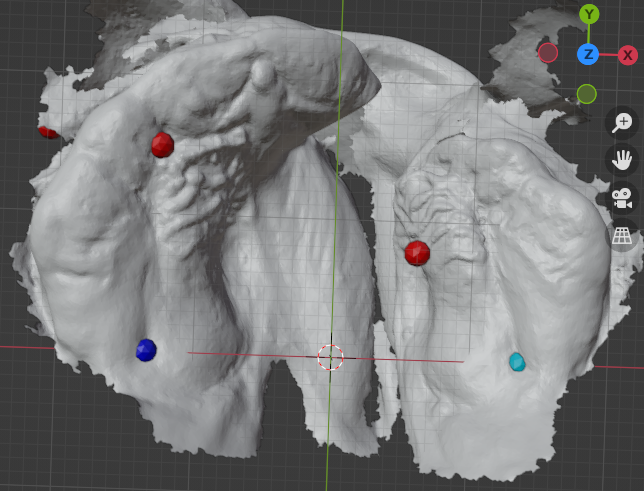

Assumptions

* X-axis orients along the widest span of the IOS.

* Z-axis can be determined using average normal over faces around the widest span.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/Y2024/iDNAM/Phase2") # my path

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
faces = np.load("/content/drive/MyDrive/Y2024/iDNAM/InvestigateEllFitV1/faces.npy")

In [6]:
ridge_ids = np.where( faces[:,3] >= 0 )[0]

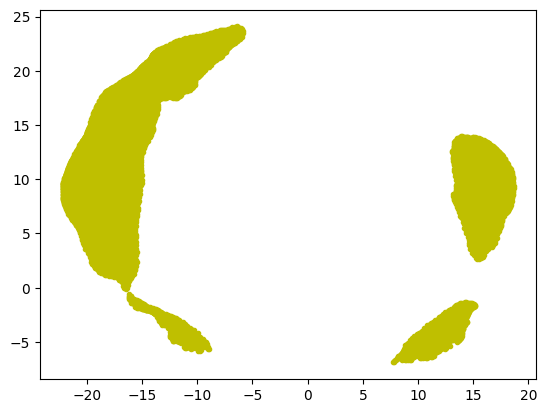

In [7]:
plt.plot(faces[ridge_ids,1], faces[ridge_ids, 2], 'y.')

# Synthesize data

Disorient the ```faces```

$$\mathbf{X}' = \mathbf{A} \mathbf{X}$$

In [39]:
def RTS(R, T, S):
    '''
    Make a Rotation-Translation-Scale Matrix, A
    $x' = A x$
    * R: (a, b, c)
    * T: (Tx, Ty, Tz)
    * S: (Sx, Sy, Sz)
    '''
    Tx, Ty, Tz = T
    Sx, Sy, Sz = S
    a, b, c = R

    TS = np.array([[Sx, 0, 0, Tx],
                   [0, Sy, 0, Ty],
                   [0, 0, Sz, Tz],
                   [0, 0,  0, 1]])

    ca = np.cos(a)
    cb = np.cos(b)
    cc = np.cos(c)
    sa = np.sin(a)
    sb = np.sin(b)
    sc = np.sin(c)
    mR = np.array([[cb*cc, sa*sb*cc - ca*sc, ca*sb*cc + sa*sc, 0],
                   [cb*sc, sa*sb*sc + ca*cc, ca*sb*sc - sa*cc, 0],
                   [-sb, sa*cb, ca*cb, 0],
                   [ 0,  0,  0, 1]])

    return mR @ TS

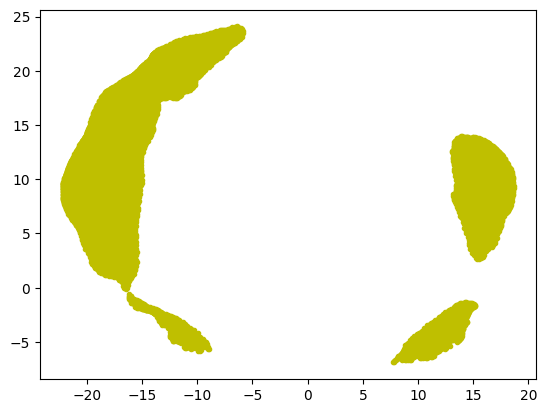

In [40]:
# Face locations (x, y, z)

# Pick only a few faces for initial study
flocs = faces[ridge_ids, 1:4]

plt.plot(flocs[:,0], flocs[:,1], 'y.')

In [34]:
flocs.shape

(12983, 3)

In [41]:
# Prep faces into 4 x N matrix

N, _ = flocs.shape

FOrg = np.c_[flocs, np.ones((N,1))]
print(FOrg.shape)

(12983, 4)


Text(0.5, 1.0, 'x-y')

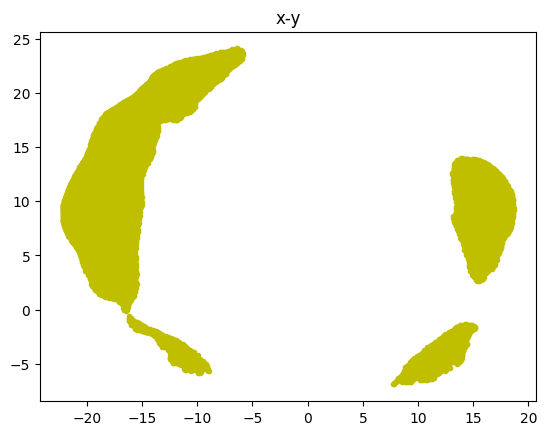

In [44]:
plt.plot(FOrg[:,0], FOrg[:,1], 'y.')
plt.title('x-y')


(-12.9349035206777, 19.78689208496748, -15.056806816712943, 27.654151535063075)

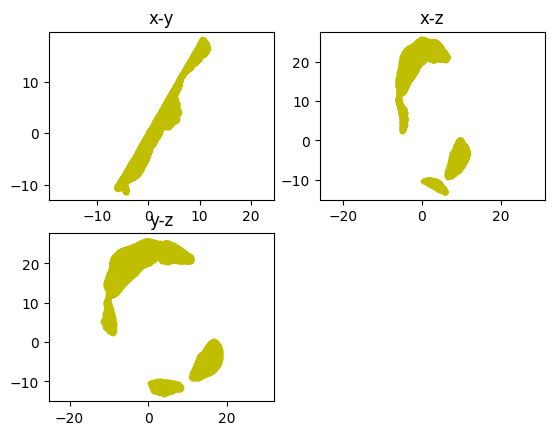

In [47]:
# Disoriented faces

D = RTS((np.pi/2, np.pi/4, np.pi/3), (0, 0, 0), (1, 1, 1))

Fdiso = (D @ FOrg.T).T

plt.subplot(2,2,1)
plt.plot(Fdiso[:,0], Fdiso[:,1], 'y.')
plt.title('x-y')
plt.axis('equal')

plt.subplot(2,2,2)
plt.plot(Fdiso[:,0], Fdiso[:,2], 'y.')
plt.title('x-z')
plt.axis('equal')

plt.subplot(2,2,3)
plt.plot(Fdiso[:,1], Fdiso[:,2], 'y.')
plt.title('y-z')
plt.axis('equal')



# PCA

In [9]:
from sklearn.decomposition import PCA

In [10]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

In [48]:
print(X.shape)

(6, 2)


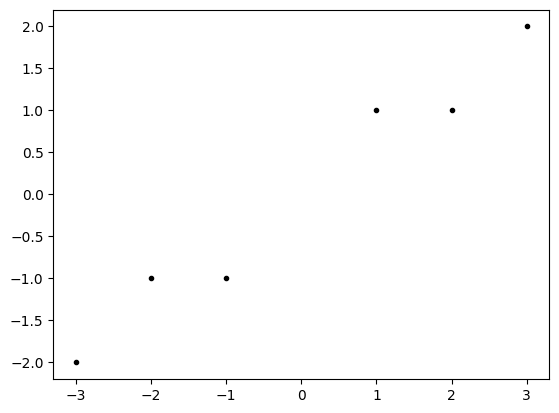

In [16]:
plt.plot(X[:,0], X[:,1], 'k.')

In [11]:
pca = PCA(n_components=2)

In [12]:
pca.fit(X)

PCA(n_components=2)

In [13]:
print(pca.explained_variance_ratio_)

[0.99244289 0.00755711]


In [14]:
pca.components_

array([[-0.83849224, -0.54491354],
       [ 0.54491354, -0.83849224]])

6.6162859339320335
0.050380732734631756
0.9924428900898052


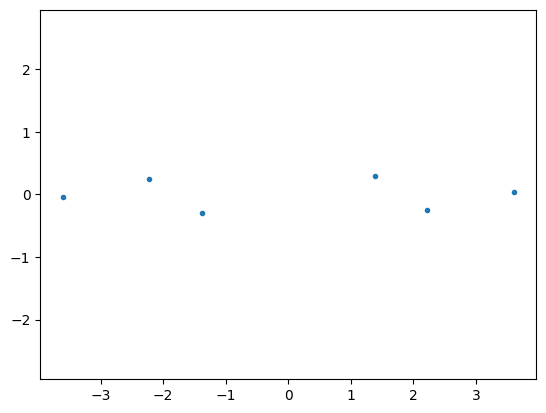

In [29]:
U = pca.components_

PX = (U @ X.T).T
plt.plot(PX[:,0], PX[:,1], '.')

plt.axis('equal')

print(np.var(PX[:,0]))
print(np.var(PX[:,1]))
print(np.var(PX[:,0])/(np.var(PX[:,0])+ np.var(PX[:,1])))





## PCA on disoriented faces

In [52]:
print('Data shape =', Fdiso[:,:3].shape)

pca = PCA(n_components=3)

Data shape = (12983, 3)


In [53]:
pca.fit(Fdiso[:,:3])

PCA(n_components=3)

In [54]:
print(pca.explained_variance_ratio_)

[0.79783681 0.20076069 0.0014025 ]


In [55]:
pca.components_

array([[ 0.27055143,  0.47808173, -0.83560744],
       [-0.40782931, -0.72932883, -0.54932205],
       [ 0.87205343, -0.48940507,  0.00234522]])

[208.20550979  52.39101659   0.36599875]


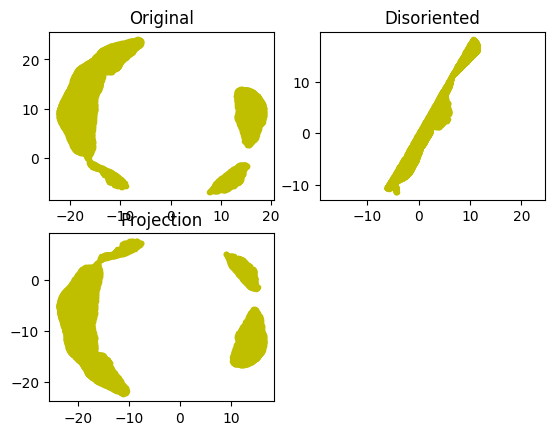

In [60]:
U = pca.components_

PX = (U @ Fdiso[:,:3].T).T

plt.subplot(2,2,1)
plt.plot(FOrg[:,0], FOrg[:,1], 'y.')
plt.title('Original')


plt.subplot(2,2,2)
plt.plot(Fdiso[:,0], Fdiso[:,1], 'y.')
plt.title('Disoriented')
plt.axis('equal')

plt.subplot(2,2,3)
plt.plot(PX[:,0], PX[:,1], 'y.')
plt.title('Projection')
plt.axis('equal')


print(np.var(PX, axis=0))


## Eigen

In [8]:
eigenvalues, eigenvectors = np.linalg.eig(np.diag((1, 2, 3)))